## Background

In this notebook, I’ll work through the **second** “Further Research” exercise at the end of [Chapter 4 of the Practical Deep Learning for Coders textbook](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb):

> Complete all the steps in this chapter using the full MNIST datasets (for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome obstacles you'll meet on the way.

## Plan of Attack

I'll start by reviewing each step of the training loop covered in this chapter (for 3s and 7s) and identify what elements need to change, why, and an a brief outline of how, in order to accommodate for all 10 digits.

### Load and Prep Data

In the chapter, we stacked tensor images of each digit to create `n` x `28` x `28` tensors (where `n` is the number of images in the training or validation folder) and then converted them to `n` x `784` tensors so that each pixel was in a one-dimensional row (corresponding to 784 parameters in the neural net in a one-dimensional row).

To handle all 10 digits, I'll need to expand this logic without too much hard-coding---I don't want to create 10 tensors individually (`stacked_zeros`, `stacked_ones`, ..., `stacked_tens`) for training and validation data.

Instead, I'll use list comprehension. First, let's look at how to access all the subfolders in the `train` and `valid` parent folders:

In [32]:
from fastai.vision.all import *

In [33]:
path = untar_data(URLs.MNIST)

In [34]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

#### Independent Variable: Images

I can iterate through `(path/'training').ls()` to see the 10 digit subfolders containing training images for the digits:

In [35]:
[path for path in (path/'training').ls()]

[Path('/root/.fastai/data/mnist_png/training/8'),
 Path('/root/.fastai/data/mnist_png/training/6'),
 Path('/root/.fastai/data/mnist_png/training/3'),
 Path('/root/.fastai/data/mnist_png/training/1'),
 Path('/root/.fastai/data/mnist_png/training/9'),
 Path('/root/.fastai/data/mnist_png/training/2'),
 Path('/root/.fastai/data/mnist_png/training/0'),
 Path('/root/.fastai/data/mnist_png/training/4'),
 Path('/root/.fastai/data/mnist_png/training/7'),
 Path('/root/.fastai/data/mnist_png/training/5')]

Taking it one layer deeper, I can nest a second list comprehension which collects individual file paths from each of the digit's folders:

In [36]:
training_files = [[file for file in path.ls()] for path in (path/'training').ls().sorted()]

Here are the paths to the first 5 images in the first folder, which corresponds to the digit `0`:

In [37]:
training_files[0][:5]

[Path('/root/.fastai/data/mnist_png/training/0/35012.png'),
 Path('/root/.fastai/data/mnist_png/training/0/2009.png'),
 Path('/root/.fastai/data/mnist_png/training/0/14472.png'),
 Path('/root/.fastai/data/mnist_png/training/0/7589.png'),
 Path('/root/.fastai/data/mnist_png/training/0/53401.png')]

And the paths to the first 5 images in the second folder, which corresponds to the digit `1`:

In [38]:
training_files[1][:5]

[Path('/root/.fastai/data/mnist_png/training/1/47434.png'),
 Path('/root/.fastai/data/mnist_png/training/1/27790.png'),
 Path('/root/.fastai/data/mnist_png/training/1/42000.png'),
 Path('/root/.fastai/data/mnist_png/training/1/15633.png'),
 Path('/root/.fastai/data/mnist_png/training/1/21958.png')]

And so on for all 10 digits

In [39]:
training_files[9][:5]

[Path('/root/.fastai/data/mnist_png/training/9/57008.png'),
 Path('/root/.fastai/data/mnist_png/training/9/28984.png'),
 Path('/root/.fastai/data/mnist_png/training/9/36162.png'),
 Path('/root/.fastai/data/mnist_png/training/9/42013.png'),
 Path('/root/.fastai/data/mnist_png/training/9/18296.png')]

In [40]:
len(training_files)

10

I'll illustrate the same for the validation set:

In [41]:
validation_files = [[file for file in path.ls()] for path in (path/'testing').ls().sorted()]

In [42]:
validation_files[0][:5]

[Path('/root/.fastai/data/mnist_png/testing/0/9095.png'),
 Path('/root/.fastai/data/mnist_png/testing/0/5990.png'),
 Path('/root/.fastai/data/mnist_png/testing/0/7505.png'),
 Path('/root/.fastai/data/mnist_png/testing/0/157.png'),
 Path('/root/.fastai/data/mnist_png/testing/0/5838.png')]

In [43]:
validation_files[9][:5]

[Path('/root/.fastai/data/mnist_png/testing/9/2009.png'),
 Path('/root/.fastai/data/mnist_png/testing/9/7298.png'),
 Path('/root/.fastai/data/mnist_png/testing/9/5565.png'),
 Path('/root/.fastai/data/mnist_png/testing/9/9483.png'),
 Path('/root/.fastai/data/mnist_png/testing/9/5705.png')]

In [44]:
len(validation_files)

10

Next, I'll flatten the list of training and validation files, convert each to a stacked tensor, convert the pixel values to floating point values, and divide by 255 so the pixel values are between 0 and 1. I referenced [this Stack Overflow post](https://stackoverflow.com/a/952952) for flattening a nested list.

To understand how it works, I find it easier to read left-to-right, broken up into two separate parts:

```python
file for (sublist in training_files) for (file in sublist)
```

In pseudocode:

```
populate this list with each file in each sublist in `training_files`
```

In [45]:
training_files = [file for sublist in training_files for file in sublist]
validation_files = [file for sublist in validation_files for file in sublist]

The dataset's [Wikimedia page](https://en.wikipedia.org/wiki/MNIST_database) says that it has 60,000 training images and 10,000 testing images. This matches the counts here:

In [46]:
len(training_files), len(validation_files)

(60000, 10000)

I'll open a couple of the files and make sure I can view the images as expected:

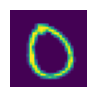

In [47]:
# this should be an image of a handwritten zero
show_image(tensor(Image.open(training_files[0])));

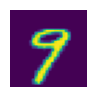

In [48]:
# this should be an image of a handwritten nine
show_image(tensor(Image.open(training_files[-1])));

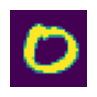

In [49]:
# this should be an image of a handwritten zero
show_image(tensor(Image.open(validation_files[0])));

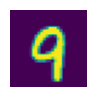

In [50]:
# this should be an image of a handwritten nine
show_image(tensor(Image.open(validation_files[-1])));

Looks good! The images are as expected. I can now move on to creating stacked floating point tensors of the training and validation images:

In [51]:
train_x = torch.stack([tensor(Image.open(o)) for o in training_files]).float()/255
train_x.shape

torch.Size([60000, 28, 28])

In [52]:
valid_x = torch.stack([tensor(Image.open(o)) for o in validation_files]).float()/255
valid_x.shape

torch.Size([10000, 28, 28])

I'll view my data one more time before changing its shape:

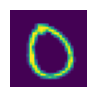

In [53]:
# this should be a zero
show_image(train_x[0]);

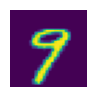

In [54]:
# this should be a nine
show_image(train_x[-1]);

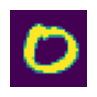

In [55]:
# this should be a zero
show_image(valid_x[0]);

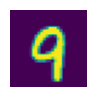

In [56]:
# this should be a nine
show_image(valid_x[-1]);

Great! I'll flatten the images so that they are 784 pixels long, instead of a 28 x 28 matrix.

In [57]:
train_x = train_x.view(-1, 28*28)
train_x.shape

torch.Size([60000, 784])

In [58]:
valid_x = valid_x.view(-1, 28*28)
valid_x.shape

torch.Size([10000, 784])

#### Dependent Variable: Labels

Now that I have the `x` (independent) variable data prepared, I'll do the same for the `y` (dependent) variable data---the labels for the images.

I'll reuse my `training_files` and `validation_files` lists as they already contain the paths to each image file, from which I'll extract the label. `path.parts` splits the path into a tuple of its individual parts (split by "/"). The parent folder (the second-to-last part of the path) of the path is the label of the image.

In [59]:
training_labels = [int(path.parts[-2]) for path in training_files]
training_labels[0], training_labels[-1]

(0, 9)

In [60]:
validation_labels = [int(path.parts[-2]) for path in validation_files]
validation_labels[0], validation_labels[-1]

(0, 9)

In [61]:
train_y = tensor(training_labels).unsqueeze(1)
train_y.shape

torch.Size([60000, 1])

In [62]:
valid_y = tensor(validation_labels).unsqueeze(1)
valid_y.shape

torch.Size([10000, 1])

Excellent! Now with the data in the right structure, I'll create a `DataLoaders` object that will be fed to the learner during training:

In [63]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([0]))

In [64]:
valid_dset = list(zip(valid_x, valid_y))
x,y = valid_dset[0]
x.shape, y

(torch.Size([784]), tensor([0]))

In [65]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [66]:
valid_dl = DataLoader(valid_dset, batch_size=256)
valid_xb, valid_yb = first(valid_dl)
valid_xb.shape, valid_yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

I combine the two `DataLoader`s into a single `DataLoaders` object:

In [67]:
dls = DataLoaders(dl, valid_dl)

And check that they contain the right amount of data:

In [68]:
len(dls.train.dataset), len(dls.valid.dataset)

(60000, 10000)

Great! With my `DataLoaders` prepared, I can move on to other aspects of the training loop that will need to be modified to handle 10 digits instead of 2.

### Create Our Model

Here is the existing model that we're using to classify two digits:

```python
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
```

It has 784 inputs and 1 output. For 10 digits, I need to adjust th number of outputs to 10:

In [69]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,10)
)

 I assume that since we have more final activations, we would also need to increase the intermediate activations from 30 to a larger number, but I'll keep it at 30 for now and then make improvements once I've actually got a successful training loop.

### Create a Loss Function

This is the main change that will take place in our training loop: using a loss function that can handle 10 digits instead of 2. In the exercise prompt, they said that we would need to:

> do some of your own research to figure out how to overcome obstacles you'll meet on the way

And I think this is probably the main obstacle to overcome. In the textbook chapter, when they trained the dataset using the built-in `Learner`, they passed it `F.cross_entropy` as the loss function:

```
learn = vision_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)

```

In the text, they introduce Cross-Entropy Loss in Chapter 5, so I'll take a detour through that chapter's relevant sections to inform me on how to create a loss function for a 10-digit classifier.

#### Cross-Entropy Loss

- Works even when our dependent variable has more than two categories.
- Results in faster and more reliable training.

As is done in the book example, I'll view one batch of our data:

In [70]:
x,y = dls.one_batch()
y[:10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

Currently, my data is not shuffled, so all the 0s are first, then all the 1s, 2s, ..., and 9s. This doesn't seem like a great way to train the model since it will learn only 1 digit's features in each batch. I'll recreate the `DataLoader`s and pass the parameter value `shuffle=True`:

In [71]:
dl = DataLoader(dset, batch_size=256, shuffle=True)
xb,yb = first(dl)
yb[:10]

tensor([[5],
        [4],
        [1],
        [3],
        [0],
        [3],
        [7],
        [2],
        [3],
        [0]])

In [72]:
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)
valid_xb, valid_yb = first(valid_dl)
valid_yb[:10]

tensor([[4],
        [7],
        [9],
        [6],
        [1],
        [8],
        [9],
        [5],
        [3],
        [0]])

In [73]:
dls = DataLoaders(dl, valid_dl)

In [74]:
len(dls.train.dataset), len(dls.valid.dataset)

(60000, 10000)

Now, when I look at one batch, I can see a variety of labels:

In [75]:
x,y = dls.one_batch()
y[:10]

tensor([[8],
        [3],
        [2],
        [7],
        [3],
        [9],
        [1],
        [6],
        [0],
        [7]])

The output predictions of the model will contain 10 predictions (one for each digit) that add up to 1. According to Chapter 5, we need to use the *softmax* function to achieve a result like this.

##### Softmax

Assume we have a scenario with 6 images and 2 possible categories (`3` and `7`):

In [76]:
torch.random.manual_seed(42);

In [77]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't just take the `sigmoid` of this directly since we want rows to add up to 1.0 (i.e., we want the probability of being a 3 plus the probability of being a 7 to add up to 1).

In [78]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In the binary case, a single pair of activations simply indicates the *relative* confidence of the input being a `3` versus being a `7`. The overall values, whether they are both high or both low, don't matter---all that matters is which is higher and by how much.

We can take the *difference* between the neural net activations because that reflects how much more sure we are of the input being a `3` than a `7`, and then take the `sigmoid` of that:

In [79]:
(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column (the probability of it being a `7`) will then just be that value subtracted from 1. The function `softmax` does this for any number of columns:

In [80]:
def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [81]:
sm_acts = softmax(acts)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

`softmax` is the multi-category equivalent of `sigmoid`. We have to use it any time we have more than two categories and the probabilities of the categories must add up to 1. Taking the exponential ensures all of our numbers are positive, and then dividing by the sum ensures that we are going to have a bunch of numbers that add up to 1.

`softmax` is the first part of the cross-entropy loss, the second part is log likelihood.

##### Log Likelihood

When we calculated the loss for our MNIST example, we used:

```python
def mnist_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()
```

We need to extend the loss function to work with more than just binary classification.

Our activations after `softmax` are between 0 and 1, and sum to 1 for each row in the batch of predictions, our targets are integers between 0 and 9.

Let's say these are our labels:

In [82]:
targ = tensor([0,1,0,1,1,0])

And these are the softmax activations:

In [83]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Then for each item of `targ`, we can use that to select the appropriate column of `sm_acts` using tensor indexing like this:

In [84]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

As long as the activation columns sum to 1 (as they will if we use softmax), we'll have a loss function that shows how well we're predicting each digit.

Making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.

PyTorch provides `nll_loss` which does the same thing as `sm_acts[range(n), targ]` except it takes the negative because when applying log afterwards we want negative numbers:

In [85]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [86]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

##### Taking the log

Here's a plot of the log function

In [87]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

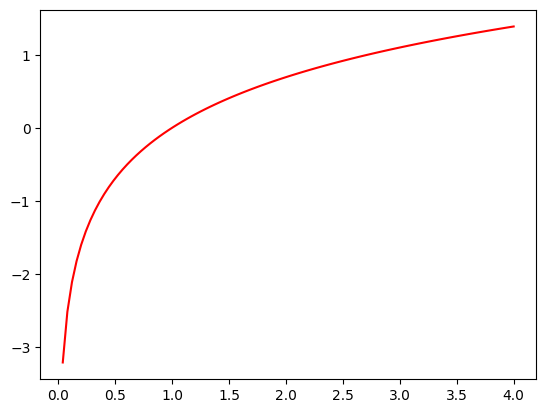

In [88]:
plot_function(torch.log, min=0, max=4)

We want to transform our probabilities to larger values so we can perform mathematical operations on them. We also want our model to learn the difference between 0.99 and 0.999 (the latter is 10 times more confident). We can use the logarithm function to transform our numbers between 0 and 1 to instead be between negative infinity and positive infinity.

Applying negative log to the softmax output:

In [89]:
targ

tensor([0, 1, 0, 1, 1, 0])

In [90]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [91]:
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [92]:
-torch.log(sm_acts[idx, targ])

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

The loss is larger for incorrect predictions (`2.0160` for the third image with activations of `0.1332` for `3`---the target value---and `0.8668` for `7`) and for unconfident correct predictions (`5.6958` for the fourth image with activations of `0.9966` for `3` and `0.0034` for `7`---the target value).


PyTorch provides the `nn.CrossEntropyLoss` class and the `F.cross_entropy` function:

In [93]:
F.cross_entropy(acts, targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [94]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

### Create a Function to Calculate Predictions, Loss and Gradients

In this section, the text has the following function to calculate predictions, loss and gradients:

```python
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()
```

I don't think anything needs to be changed here. In my [implementation of a `BasicLearner`](http://vishalbakshi.com/blog/posts/2023-07-24-basiclearner/2023_07_23_basiclearner.html) I have generalized that function as:

```python
def calc_grad(self, xb, yb, model):
    preds = self.model(xb)
    loss = self.loss_func(preds, yb)
    loss.backward()
```

I believe that should work fine with `nn.CrossEntropyLoss()` as the function assigned to my `self.loss_func` parameter.

### Create an Optimizer

The optimizer's functionality (stepping the parameters and setting the gradients to zero) will not need to be changed to handle 10 digits.

### Create a Function to Train One Epoch

The steps needed to train an epoch will not need to be changed to handle 10 digits:

```python
def train_epoch(model):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()
```

### Create a Function to Calculate a Metric for One Batch

Along with the loss function, this is the second big change when dealing with 10 digits instead of 2. Currently, in text, we use a `batch_accuracy` function as the metric during training:

```python
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()
```

For each batch the following steps take place in calculating accuracy:

- Calculate the sigmoid value of the predictions.
- Determine which predictions are greater than 0.5 and if they are, whether they are correctly labeled as `3`s.
- Return the mean value of the previous tensor, which will calculate as number of correct predictions / number of total predictions.

To understand how to calculate accuracy for a dataset with 10 digits, I'll create an example calculation similar to what they did in chapter 5 for illustrating the softmax/log likelihood example. Suppose we have 6 images with 10 possible categories (`0`, `1`, `2`, `3`, `4`, `5`, `6`, `7`, `8`, `9`) and 6 labels:

In [95]:
torch.random.manual_seed(42);

In [96]:
acts = torch.randn((6,10))*2
acts

tensor([[ 3.8538,  2.9746,  1.8014, -4.2110,  1.3568, -2.4691, -0.0861, -3.2093,
         -1.5043,  3.2974],
        [-0.7850, -2.8072, -1.4558, -1.1189, -1.5377,  1.5249,  3.2846, -0.3192,
         -0.9948,  0.8792],
        [-1.5163,  2.1566,  1.6016,  3.3612,  2.5582,  2.5928,  1.2209,  2.6695,
         -0.4632,  0.0835],
        [-0.5032,  1.7197, -2.7693, -1.7425, -0.4467,  3.4347,  0.6378, -0.8490,
          0.6114, -1.5492],
        [-3.1151,  1.9913, -1.7596, -1.2023,  0.7345,  0.3508,  2.7703, -0.8917,
          2.8903,  1.7128],
        [ 4.4362,  1.0463,  2.3507,  1.1223, -0.9055, -1.5436, -0.3444,  1.0476,
          0.1132,  0.8526]])

In [97]:
targ = tensor([1,6,4,5,8,0])

We take the `softmax` of the activations so that each row sums to `1`:

In [98]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[4.4919e-01, 1.8645e-01, 5.7688e-02, 1.4122e-04, 3.6982e-02, 8.0615e-04,
         8.7362e-03, 3.8453e-04, 2.1156e-03, 2.5751e-01],
        [1.2639e-02, 1.6728e-03, 6.4621e-03, 9.0509e-03, 5.9539e-03, 1.2731e-01,
         7.3978e-01, 2.0136e-02, 1.0246e-02, 6.6747e-02],
        [2.4815e-03, 9.7686e-02, 5.6077e-02, 3.2583e-01, 1.4597e-01, 1.5110e-01,
         3.8323e-02, 1.6314e-01, 7.1126e-03, 1.2288e-02],
        [1.4239e-02, 1.3148e-01, 1.4766e-03, 4.1232e-03, 1.5065e-02, 7.3058e-01,
         4.4562e-02, 1.0075e-02, 4.3404e-02, 5.0024e-03],
        [8.6558e-04, 1.4289e-01, 3.3576e-03, 5.8621e-03, 4.0662e-02, 2.7705e-02,
         3.1141e-01, 7.9971e-03, 3.5109e-01, 1.0816e-01],
        [7.7830e-01, 2.6240e-02, 9.6708e-02, 2.8313e-02, 3.7265e-03, 1.9688e-03,
         6.5311e-03, 2.6273e-02, 1.0321e-02, 2.1619e-02]])

In [99]:
sm_acts.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

The model's prediction is the digit (index) with the largest probability.

In [100]:
sm_acts.max(dim=1).indices

tensor([0, 6, 3, 5, 8, 0])

The accuracy is the average of the following boolean tensor (the number of correct predictions / the number of total predictions):

In [101]:
sm_acts.max(dim=1).indices == targ

tensor([False,  True, False,  True,  True,  True])

In [102]:
(sm_acts.max(dim=1).indices == targ).float().mean().item()

0.6666666865348816

As a function, this is what `batch_accuracy` would look like for the 10-digit classifier:

```python
def batch_accuracy(xb, yb):
  preds = torch.softmax(xb, dim=1)
  preds = preds.max(dim=1).indices
  return (preds == yb).float().mean().item()
```

### Create a Function to Calculate the Metric for One Epoch

This function will be the same for the 10-digit classifier as it was for the 2-digit classifier:

```python
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)
```

### Create a Function for the Training Loop

This function will be the same for the 10-digit classifier as it was for the 2-digit classifier:

```python
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')
```

## `MNIST` Training Loop

With that overview under my belt, I'll walk through the training loop with real code and data.

### Load and Prep Data

I've already loaded and prepared a shuffled `DataLoaders` object, so in this step all I need to do is check it's size and shape:

In [228]:
len(dls.train.dataset), len(dls.valid.dataset)

(60000, 10000)

In [229]:
x,y = first(dls.train)
x.shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [230]:
x,y = first(dls.valid)
x.shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [231]:
# check that the digits are shuffled
y[:5]

tensor([[6],
        [8],
        [2],
        [0],
        [6]])

### Create Our Model

For the first iteration of the training loop, I'll use a similarly structured model as before:

In [232]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

### Create a Loss Function

The loss function that I will use is `nn.CrossEntropyLoss`:

In [262]:
mnist_loss = nn.CrossEntropyLoss()

### Create a function to Calculate Predictions, Loss and Gradients

This function is the same as before:

In [273]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  # yb has to be a 0- or 1-D tensor
  loss = mnist_loss(preds, yb.squeeze())
  loss.backward()

### Create an Optimizer

I'll use the `BasicOptim` optimizer defined in chapter 4:

In [235]:
class BasicOptim:
  def __init__(self,params,lr): self.params,self.lr = list(params),lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

In [236]:
lr = 0.1

In [237]:
opt = BasicOptim(simple_net.parameters(), lr)

### Create a Function to Train One Epoch

Same as before:

In [274]:
def train_epoch(model):
  for xb,yb in dls.train:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

### Create a Function to Calculate a Metric for One Batch

The metric of interest is accuracy, and I'll define a new `batch_accuracy` function to handle 10-digits instead of 2:

In [275]:
def batch_accuracy(xb, yb):
  preds = torch.softmax(xb, dim=1)
  preds = preds.max(dim=1).indices
  # squeeze yb so it's the same shape as preds
  return (preds == yb.squeeze()).float().mean().item()

### Create a Function to Calculate the Metric for One Epoch

Same as before, but iterating through `dls.valid` instead of a `valid_dl` `DataLoader`:

In [276]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in dls.valid]
  return round(torch.tensor(accs).mean().item(), 4)

### Train the Model for One Epoch

Since I have a new loss function and accuracy function, I'll train the model for one batch manually and then use a loop for multiple epochs.

In [288]:
# create a fresh model
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [289]:
# create a fresh optimizer
opt = BasicOptim(simple_net.parameters(), lr=0.01)

In [290]:
# get one batch of the training data
xb, yb = first(dls.train)

In [291]:
# calculate predictions
preds = simple_net(xb)

In [292]:
preds.shape

torch.Size([256, 10])

`nn.CrossEntropyLoss()` expects a 0- or 1-dimensional tensor for the labels (targets) so I have to `squeeze` the label tensor.

In [293]:
# calculate loss
loss = mnist_loss(preds, yb.squeeze())

In [294]:
loss

tensor(2.3140, grad_fn=<NllLossBackward0>)

In [295]:
# calculate gradients
loss.backward()

In [296]:
# step the weights
opt.step()
opt.zero_grad()

In [297]:
# calculate accuracy using validation set
validate_epoch(simple_net)

0.1239

### Create a Function for the Training Loop

Now that I've tested my loss and accuracy function for one epoch, I can loop through the training process for multiple epochs:

In [302]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [303]:
# create a fresh model
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [304]:
# create a fresh optimizer
opt = BasicOptim(simple_net.parameters(), lr=0.001)

In [305]:
train_model(simple_net, 40)

0.2094 0.2522 0.3821 0.5208 0.6083 0.6399 0.6674 0.6776 0.6828 0.6894 0.701 0.7071 0.7221 0.7418 0.7549 0.7735 0.7852 0.7896 0.8061 0.8089 0.8212 0.8188 0.8264 0.8309 0.8313 0.8336 0.8378 0.8397 0.8462 0.8487 0.8511 0.8546 0.8545 0.8545 0.8597 0.8604 0.8618 0.8609 0.8612 0.8662 

After training the model for 40 epochs with a learning rate of `0.001`, I achieve an accuracy of about 86%.

I'll now test my model and see if it predicts digits correctly:

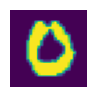

In [342]:
test_x = dls.valid.dataset[1][0]
show_image(test_x.view(-1,28,28));

In [343]:
preds = simple_net(test_x)
preds = torch.softmax(preds, dim=0)

# this should be 0
preds.argmax().item()

0

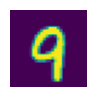

In [344]:
test_x = dls.valid.dataset[-1][0]
show_image(test_x.view(-1,28,28));

In [346]:
preds = simple_net(test_x)
preds = torch.softmax(preds, dim=0)

# this should be 9
preds.argmax().item()

9

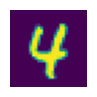

In [349]:
test_x = dls.valid.dataset[5000][0]
show_image(test_x.view(-1,28,28));

In [350]:
preds = simple_net(test_x)
preds = torch.softmax(preds, dim=0)
# this should be 4
preds.argmax().item()

4

Look good! The model is correctly predicting images.

Next, I'll modify my `BasicLearner` class (and call it `MNISTLearner`) so that it can handle training the full MNIST dataset.

## `MNISTLearner` Class

I'll build off my [`BasicLearner` class](http://vishalbakshi.com/blog/posts/2023-07-24-basiclearner/2023_07_23_basiclearner.html) by incorporating some changes (mainly, changing `yb` to `yb.squeeze()` when calculating loss).


I'll also add a `Time` column which displays how much time it took to train each epoch.

In [441]:
import time

In [446]:
class MNISTLearner:
  def __init__(self, dls, model, opt_func, loss_func, metric):
    self.dls = dls
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metric = metric

  def calc_grad(self, xb, yb, model):
    # calculates loss and gradients
    preds = self.model(xb)
    loss = self.loss_func(preds, yb.squeeze())
    # store the loss of each batch
    # later to be averaged across the epoch
    self.loss = torch.cat((self.loss, tensor([loss])))
    loss.backward()

  def train_epoch(self):
    for xb,yb in self.dls.train:
      self.calc_grad(xb, yb, self.model)
      # steps the weights
      self.opt.step()
      # resets gradient to zero
      self.opt.zero_grad()

  def validate_epoch(self):
    accs = [self.metric(self.model(xb), yb) for xb,yb in self.dls.valid]
    # calculates mean accuracy across validation set
    return round(torch.tensor(accs).mean().item(), 4)

  def train_model(self, model, epochs):
    print(f"{'Epoch':<8}{'Train Loss':<14}{self.metric.__name__:<16}{'Time (s)'}")
    for i in range(self.epochs):
      start_time = time.time()
      self.loss = tensor([])
      self.train_epoch()
      end_time = round(time.time() - start_time,4)
      mean_loss = round(self.loss.mean().item(), 4)
      mean_metric = self.validate_epoch()
      print(f"{i:<8}{mean_loss:<14}{mean_metric:<16}{end_time}")

  def fit(self, epochs, lr):
    self.lr = lr
    self.epochs = epochs
    # instantiate optimizer
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    # run training loop
    self.train_model(self.model, self.epochs)

  def predict(self, x):
    prediction = self.model(x)
    # predictions should add up to 1.
    prediction = torch.softmax(prediction, dim=0)
    # return probability and label
    return prediction.max(), prediction.argmax().item()

In [447]:
# create a fresh model
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [448]:
# instantiate MNISTLearner
learner = MNISTLearner(dls=dls,
                       model=simple_net,
                       opt_func=BasicOptim,
                       loss_func=nn.CrossEntropyLoss(),
                       metric=batch_accuracy)

In [449]:
# run training loop for 40 epochs
learner.fit(epochs=40, lr=0.001)

Epoch   Train Loss    batch_accuracy  Time (s)
0       2.3025        0.1194          0.7052
1       2.2658        0.1836          0.6548
2       2.2273        0.2968          0.6137
3       2.1825        0.3777          0.5981
4       2.1311        0.4608          0.6194
5       2.0769        0.5362          0.6074
6       2.0208        0.5938          0.7253
7       1.9622        0.6406          0.7677
8       1.9025        0.6746          0.6411
9       1.8408        0.6964          0.6073
10      1.7774        0.7209          0.6361
11      1.7121        0.7318          0.5707
12      1.6454        0.7428          0.886
13      1.5776        0.7583          1.0406
14      1.5094        0.7699          0.5713
15      1.4416        0.7759          0.5628
16      1.3759        0.7796          0.5508
17      1.3118        0.7882          0.5552
18      1.2518        0.7876          0.6065
19      1.1946        0.7981          0.5996
20      1.1411        0.801           0.5771
21      1

Great! Next, I'll test predictions of this model, one image per digit, to see how it performs. Ideally, I would have a test dataset set aside for this part, but I'll use the validation set instead:

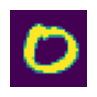

In [450]:
test_x = dls.valid.dataset[0][0]
show_image(test_x.view(-1,28,28));

In [451]:
# this should be 0
learner.predict(test_x)

(tensor(0.9909, grad_fn=<MaxBackward1>), 0)

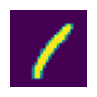

In [452]:
test_x = dls.valid.dataset[1000][0]
show_image(test_x.view(-1,28,28));

In [453]:
# this should be 1
learner.predict(test_x)

(tensor(0.7081, grad_fn=<MaxBackward1>), 1)

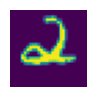

In [454]:
test_x = dls.valid.dataset[2600][0]
show_image(test_x.view(-1,28,28));

In [455]:
# this should be 2
learner.predict(test_x)

(tensor(0.5737, grad_fn=<MaxBackward1>), 4)

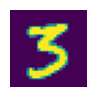

In [456]:
test_x = dls.valid.dataset[3600][0]
show_image(test_x.view(-1,28,28));

In [457]:
# this should be 3
learner.predict(test_x)

(tensor(0.7091, grad_fn=<MaxBackward1>), 3)

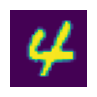

In [458]:
test_x = dls.valid.dataset[4600][0]
show_image(test_x.view(-1,28,28));

In [459]:
# this should be 4
learner.predict(test_x)

(tensor(0.8390, grad_fn=<MaxBackward1>), 4)

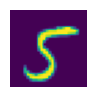

In [460]:
test_x = dls.valid.dataset[5600][0]
show_image(test_x.view(-1,28,28));

In [461]:
# this should be 5
learner.predict(test_x)

(tensor(0.4645, grad_fn=<MaxBackward1>), 5)

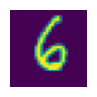

In [462]:
test_x = dls.valid.dataset[6600][0]
show_image(test_x.view(-1,28,28));

In [463]:
# this should be 6
learner.predict(test_x)

(tensor(0.9363, grad_fn=<MaxBackward1>), 6)

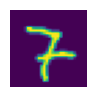

In [464]:
test_x = dls.valid.dataset[7100][0]
show_image(test_x.view(-1,28,28));

In [465]:
# this should be 7
learner.predict(test_x)

(tensor(0.4163, grad_fn=<MaxBackward1>), 1)

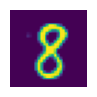

In [466]:
test_x = dls.valid.dataset[8500][0]
show_image(test_x.view(-1,28,28));

In [467]:
# this should be 8
learner.predict(test_x)

(tensor(0.8225, grad_fn=<MaxBackward1>), 8)

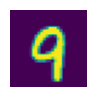

In [468]:
test_x = dls.valid.dataset[-1][0]
show_image(test_x.view(-1,28,28));

In [469]:
# this should be 9
learner.predict(test_x)

(tensor(0.5962, grad_fn=<MaxBackward1>), 9)

Manually testing the model, it accurately predicted 80% of the digits, which makes sense given the model accuracy was 85% at the end of training.

## Improving the Model

I wonder if adding another layer to my neural net will improve the model's accuracy. I'll arbitrarily choose an intermediate number of activations as 784/2:

In [476]:
# create a fresh model
simple_net = nn.Sequential(
    nn.Linear(28*28, 392),
    nn.ReLU(),
    nn.Linear(392, 30),
    nn.ReLU(),
    nn.Linear(30,10)
)

In [477]:
# instantiate MNISTLearner
learner = MNISTLearner(dls=dls,
                       model=simple_net,
                       opt_func=BasicOptim,
                       loss_func=nn.CrossEntropyLoss(),
                       metric=batch_accuracy)

In [478]:
# run training loop for 40 epochs
learner.fit(epochs=40, lr=0.005)

Epoch   Train Loss    batch_accuracy  Time (s)
0       2.2885        0.2899          1.771
1       2.2213        0.3874          2.2249
2       2.1157        0.5674          1.6725
3       1.9426        0.6493          1.7144
4       1.6701        0.708           1.5923
5       1.3271        0.7588          1.6464
6       1.0312        0.7899          1.7139
7       0.8426        0.8186          1.9155
8       0.726         0.8276          1.8586
9       0.6467        0.8443          1.6758
10      0.5893        0.8518          1.6447
11      0.5452        0.8624          1.6898
12      0.5098        0.8768          1.653
13      0.482         0.8792          1.7703
14      0.4598        0.8817          2.0231
15      0.4412        0.8829          1.6538
16      0.4255        0.8902          1.6392
17      0.4125        0.8919          1.6541
18      0.4017        0.8894          1.6532
19      0.3917        0.8951          1.6696
20      0.3834        0.8965          2.1116
21      0.

Cool! I ended up with a significant improvement in accuracy, although the training took about 3 times as long to finish.

I'll again test all 10 digits to see how well it predicts them:

In [494]:
actuals = list(range(10))
for idx, val in enumerate([0, 1000, 2600, 3600, 4600, 5600, 6600, 7100, 8500, -1]):
  test_x = dls.valid.dataset[val][0]
  print(f"{'Actual:':<8}{actuals[idx]:<4} {'Prediction: ':<12}{learner.predict(test_x)}")


Actual: 0    Prediction: (tensor(0.9990, grad_fn=<MaxBackward1>), 0)
Actual: 1    Prediction: (tensor(0.9758, grad_fn=<MaxBackward1>), 1)
Actual: 2    Prediction: (tensor(0.8626, grad_fn=<MaxBackward1>), 4)
Actual: 3    Prediction: (tensor(0.9606, grad_fn=<MaxBackward1>), 3)
Actual: 4    Prediction: (tensor(0.9981, grad_fn=<MaxBackward1>), 4)
Actual: 5    Prediction: (tensor(0.9614, grad_fn=<MaxBackward1>), 5)
Actual: 6    Prediction: (tensor(0.9982, grad_fn=<MaxBackward1>), 6)
Actual: 7    Prediction: (tensor(0.8736, grad_fn=<MaxBackward1>), 7)
Actual: 8    Prediction: (tensor(0.9901, grad_fn=<MaxBackward1>), 8)
Actual: 9    Prediction: (tensor(0.9784, grad_fn=<MaxBackward1>), 9)


My manual testing resulted in the model predicting 90% of the digits correctly, which makes sense given the increase in accuracy of the model.

## Further Improvements

There are of course unlimited improvements when it comes to trying out different models. I could vary the number of intermediate activations, number of layers, and overall architecture.

I could also add a validation loss to understand when the model is overfitting.

Overall, I am thrilled that this exercise was successful, and had a really fun time working through it. I hope you enjoyed this blog post!